# Module Initialization
Here we will load all data and relevant modules. This will access helpful utilities aswell.

In [97]:
import numpy as np 
import matplotlib.pyplot as plt
from utils.utils import *
from nn.rnn import *
import torch, torchaudio, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
#for macOS
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [9]:
X_test = np.load(add_path("X_test.npy"))
y_test = np.load(add_path("y_test.npy"))
person_train_valid = np.load(add_path("person_train_valid.npy"))
X_train_valid = np.load(add_path("X_train_valid.npy"))
y_train_valid = np.load(add_path("y_train_valid.npy"))
person_test = np.load(add_path("person_test.npy"))

FileNotFoundError: [Errno 2] No such file or directory: 'data/_MACOSX/project/X_test.npy'

Check the shape of our data

In [12]:
print('Training/Valid data shape: {}'.format(X_train_valid.shape))
print('Test data shape: {}'.format(X_test.shape))
print('Training/Valid Target shape: {}'.format(y_train_valid.shape))
print('Test Target shape: {}'.format(y_test.shape))
print('Person Train/Valid shape: {}'.format(person_train_valid.shape))
print('Person Test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid Target shape: (2115,)
Test Target shape: (443,)
Person Train/Valid shape: (2115, 1)
Person Test shape: (443, 1)


# Data Preprocessing

Here we will perfrom some data preprocessing to create a larger dataset and improve the generalization of our network.

## Outline
**Describe the preprocessing that will be done**

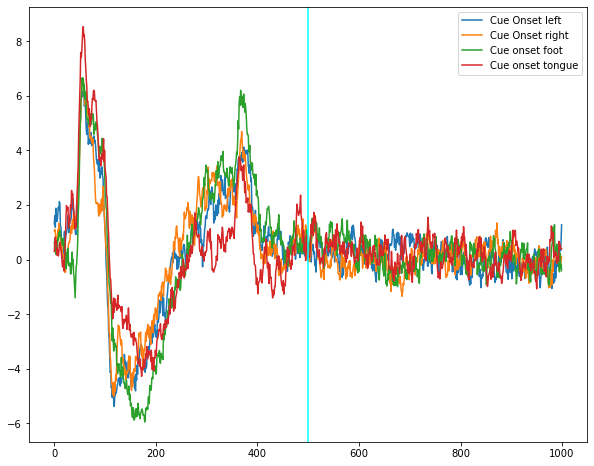

In [13]:
y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [14]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [16]:
# to_categorical is a tensorflow command so here it is in python
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [105]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# # Converting the labels to categorical variables for multiclass classification
# y_train = to_categorical(y_train, 4)
# y_valid = to_categorical(y_valid, 4)
# y_test = to_categorical(y_test_prep, 4)
# print('Shape of training labels after categorical conversion:',y_train.shape)
# print('Shape of validation labels after categorical conversion:',y_valid.shape)
# print('Shape of test labels after categorical conversion:',y_test.shape)

# # Adding width of the segment to be 1
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
# x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
# x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
# print('Shape of training set after adding width info:',x_train.shape)
# print('Shape of validation set after adding width info:',x_valid.shape)
# print('Shape of test set after adding width info:',x_test.shape)


# # Reshaping the training and validation dataset
# x_train = np.swapaxes(x_train, 1,3)
# x_train = np.swapaxes(x_train, 1,2)
# x_valid = np.swapaxes(x_valid, 1,3)
# x_valid = np.swapaxes(x_valid, 1,2)
# x_test = np.swapaxes(x_test, 1,3)
# x_test = np.swapaxes(x_test, 1,2)
# print('Shape of training set after dimension reshaping:',x_train.shape)
# print('Shape of validation set after dimension reshaping:',x_valid.shape)
# print('Shape of test set after dimension reshaping:',x_test.shape)

# changing input of Tonmoy's data augmentation to flat array
# Reshaping the training and validation dataset (Need to figure out how to shape data properly)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
# x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2]))
# print('')
# print('Reshaping the training and validation dataset')
# print('Shape of training set:',x_train.shape)
# print('Shape of training labels:',y_train.shape)
# print('Shape of validation set:',x_valid.shape)
# print('Shape of validation labels:',y_valid.shape)

# change to tensor
x_train = Variable(torch.Tensor(x_train))
x_valid = Variable(torch.Tensor(x_valid))
y_train = Variable(torch.Tensor(y_train))
y_train = torch.reshape(y_train,  (y_train.shape[0], 1)) 
y_valid = Variable(torch.Tensor(y_valid))
y_valid = torch.reshape(y_valid,  (y_valid.shape[0], 1)) 
print("Training Shape", x_train.shape, y_train.shape)
print("Valid Shape", x_valid.shape, y_valid.shape)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772, 16)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Training Shape torch.Size([6960, 22, 250]) torch.Size([6960, 1])
Valid Shape torch.Size([1500, 22, 250]) torch.Size([1500, 1])


In [25]:
# TODO: preprocesing code from Zichao

# Dataset Augmentation

Here we will augment our data set to increase the size of our training set. This will helop us to prevent overfitting and make our network more generalizable.

In [24]:
# Create Data set with gaussian noise
std_data = np.std(X_train_valid)
X_train_valid_gn = np.random.randn(*X_train_valid.shape)*std_data/10 +X_train_valid

# Create data set with single sample shift
X_train_valid_delay = np.roll(X_train_valid,1,axis=2)

# Create data set that is scaled 
X_train_valid_half = X_train_valid/2

# RNN Hyperparameter Tuning

# Structure


In [164]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [165]:
num_epochs = 10 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 250 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [166]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train.shape[1])
criterion = torch.nn.MSELoss()    # NEED to change this to softmax but getting error
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [167]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(x_train) #forward pass
  optimizer.zero_grad() #calculate the gradient, manually setting to 0
    
  loss = criterion(outputs, y_train)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 3.76168
Epoch: 1, loss: 3.39769
Epoch: 2, loss: 3.06834
Epoch: 3, loss: 2.75728
Epoch: 4, loss: 2.45715
Epoch: 5, loss: 2.17132
Epoch: 6, loss: 1.90925
Epoch: 7, loss: 1.68428
Epoch: 8, loss: 1.51429
Epoch: 9, loss: 1.41576
